<a href="https://colab.research.google.com/github/JLopez86/fastbook/blob/master/04_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#4. Transferencia de Aprendizaje

##4.1. Instalación de Requerimientos

In [ ]:
# Instalación del cliente Neptune
! pip install neptune-client[fastai]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 439 kB 32.3 MB/s 
     |████████████████████████████████| 132 kB 67.0 MB/s 
     |████████████████████████████████| 55 kB 3.5 MB/s 
     |████████████████████████████████| 184 kB 20.5 MB/s 
     |████████████████████████████████| 829 kB 6.3 MB/s 
     |████████████████████████████████| 79 kB 8.8 MB/s 
     |████████████████████████████████| 10.3 MB 63.4 MB/s 
     |████████████████████████████████| 140 kB 72.3 MB/s 
     |████████████████████████████████| 67 kB 7.1 MB/s 
     |████████████████████████████████| 139 kB 73.2 MB/s 
     |████████████████████████████████| 62 kB 1.6 MB/s 
     |████████████████████████████████| 127 kB 68.2 MB/s 
     |████████████████████████████████| 66 kB 5.8 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491071 sha256=ee14afa2ffc09c0d0be6626f5609cbeb86d528fd979bb7ce0724769d34b0e5d4
  Sto

In [ ]:
# Importación de librerías
from google.colab import files
from google.colab import drive
from fastai.vision.all import *
import os
import shutil
import torch
import random
#from fastai.callback.tensorboard import TensorBoardCallback
from fastai.callback.hook import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#print('matplotlib: {}'.format(matplotlib.__version__))

# Importación de librerías para integración Fastai | Neptune
import neptune.new as neptune
from neptune.new.integrations.fastai import NeptuneCallback

#from nbdev.showdoc import show_doc

# Verificación de activación de GPU
print(torch.cuda.is_available())

True


In [ ]:
# Montar el drive y extraer el conjunto de datos
drive.mount('/content/drive')
# Descomprimir imágenes para entrenamiento y validación
! unzip /content/drive/MyDrive/Colab\ Notebooks/DPI\ -\ Anomalias\ en\ Hojas/Plant_Disease.zip
# Descomprimir imágenes para pruebas
! unzip /content/drive/MyDrive/Colab\ Notebooks/DPI\ -\ Anomalias\ en\ Hojas/Validation.zip

Mounted at /content/drive
Archive:  /content/drive/MyDrive/Colab Notebooks/DPI - Anomalias en Hojas/Plant_Disease.zip
   creating: Plant_Disease/
   creating: Plant_Disease/Healthy/
  inflating: Plant_Disease/Healthy/94b531898979f38b.jpg  
  inflating: Plant_Disease/Healthy/97f3cad16524509b.jpg  
  inflating: Plant_Disease/Healthy/83f7381b7cace01c.jpg  
  inflating: Plant_Disease/Healthy/86c8358db7d560ad.jpg  
  inflating: Plant_Disease/Healthy/8e6a823cce9ff40c.jpg  
  inflating: Plant_Disease/Healthy/85edd994308a6f65.jpg  
  inflating: Plant_Disease/Healthy/84f60a857fb26bc1.jpg  
  inflating: Plant_Disease/Healthy/818a15d52bb75f0e.jpg  
  inflating: Plant_Disease/Healthy/9f2174f703ca3961.jpg  
  inflating: Plant_Disease/Healthy/88d8c872ceb7a2b6.jpg  
  inflating: Plant_Disease/Healthy/90c790666f674f58.jpg  
  inflating: Plant_Disease/Healthy/93a7c1dd2fe04f20.jpg  
  inflating: Plant_Disease/Healthy/98d2ed0b33c866d9.jpg  
  inflating: Plant_Disease/Healthy/8bda74e18b458f0d.jpg  
  infl

##4.2. Definición del Conjunto de Datos

In [ ]:
# Cargar el conjunto de datos en memoria
path = 'Plant_Disease'
files = get_image_files(path)

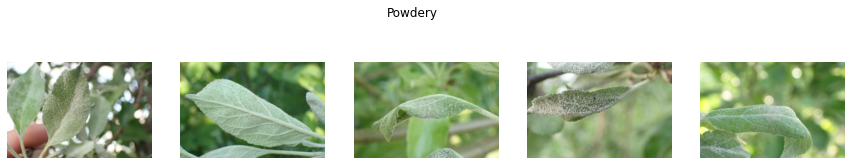

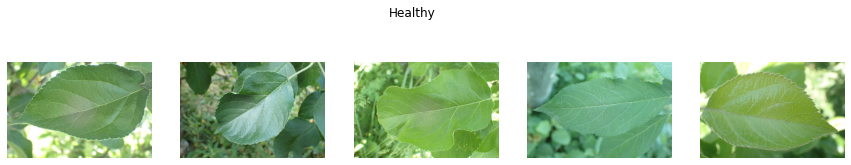

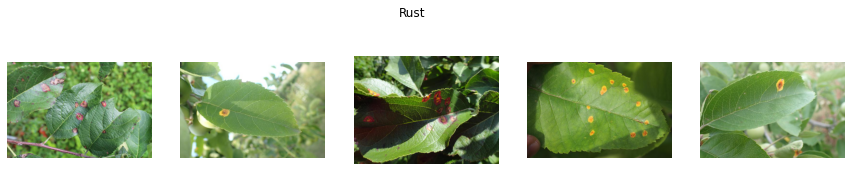

In [ ]:
# Etiquetas del dataset y visualización de las muestras
labels = os.listdir(path)
dataset = {}
for label in labels:
  images = get_image_files(path, folders=label)
  dataset[label] =len(images)
  sample = [load_image(image) for image in images.shuffle()[:5]]
  show_images(sample, nrows=1, ncols=5, imsize=3, suptitle=label)

In [ ]:
# Cargar el conjunto de datos y distribuir para entrenamiento y validación
dls = ImageDataLoaders.from_folder(path, files, valid_pct=0.2, item_tfms=Resize(224), batch_tfms= aug_transforms(size=224), pretrained=False, device=torch.device('cuda'))

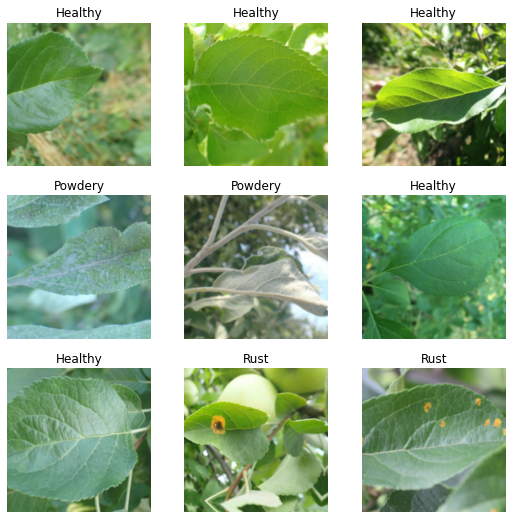

In [ ]:
dls.show_batch()

##4.3. Entrenamiento del Modelo

In [ ]:
#learn = vision_learner(dls, resnet34, metrics=accuracy)
#learn = vision_learner(dls, resnet101, metrics=accuracy)
learn = vision_learner(dls, resnet50, path='/content/', model_dir='models', metrics=[accuracy, error_rate], cbs=ActivationStats(with_hist=True))


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
learn.summary()

/usr/local/lib/python3.8/dist-packages/fastai/callback/core.py:69: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


Sequential (Input shape: 64 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 112 x 112 
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 56 x 56   
MaxPool2d                                                      
Conv2d                                    4096       False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
____________________________________________________________________________
                     64 x 256 x 56 x 56  
Conv2d                                    16384      False     
BatchNorm2d                        

SuggestedLRs(valley=0.0012022644514217973)

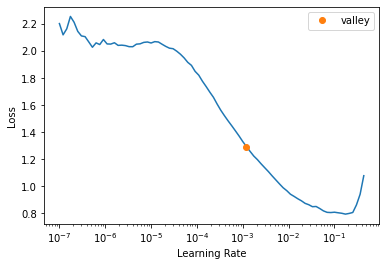

In [ ]:
learn.lr_find()

In [ ]:
learn.fine_tune(5, 0.0012)

epoch,train_loss,valid_loss,accuracy,error_rate,time


KeyboardInterrupt: ignored

##4.4. Intepretación de Resultados

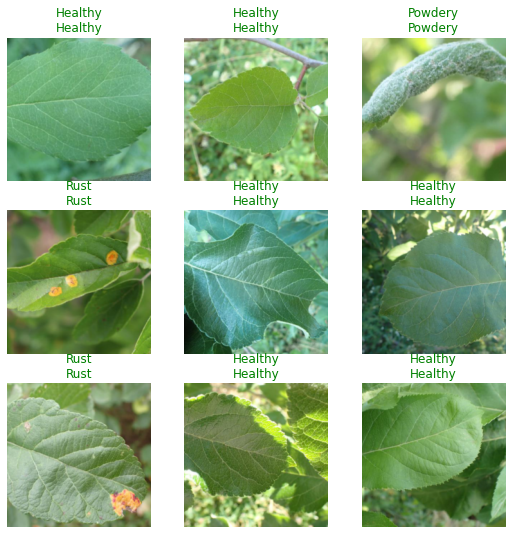

In [ ]:
learn.show_results()

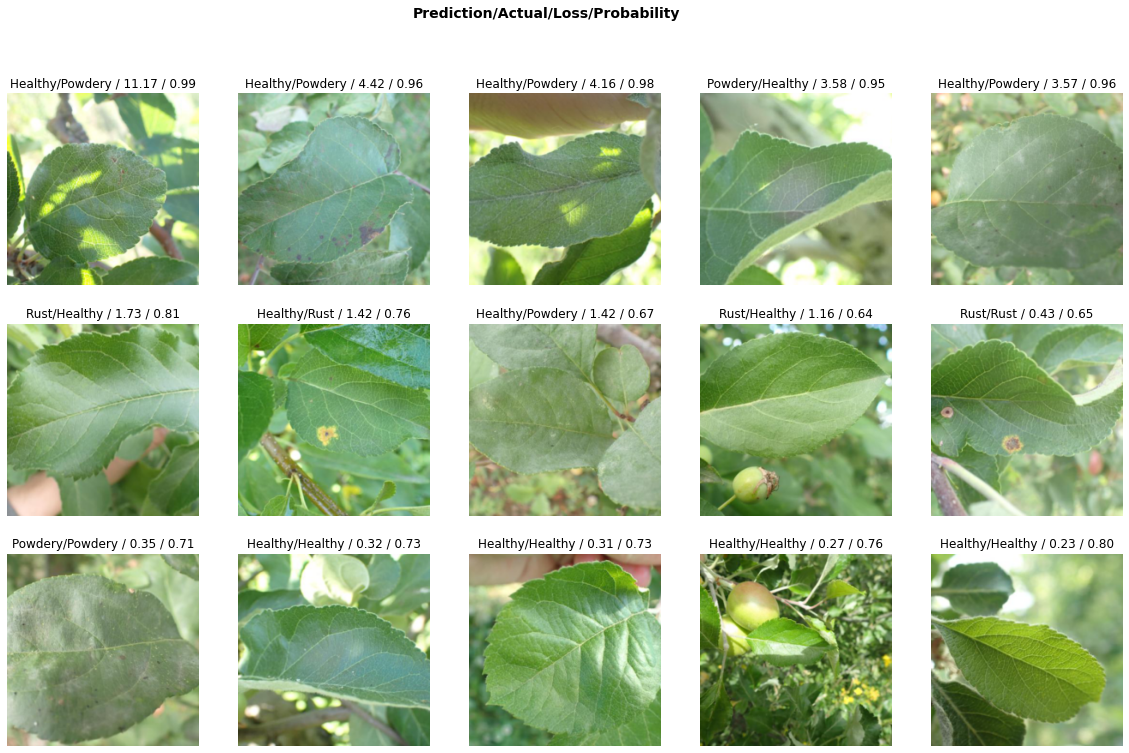

In [ ]:
interp = Interpretation.from_learner(learn)
interp.plot_top_losses(15, figsize=(20,12))

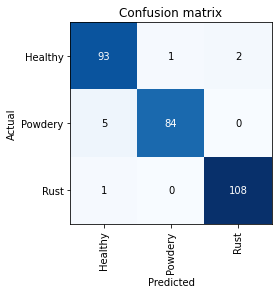

In [ ]:
cinterp = ClassificationInterpretation.from_learner(learn)
cinterp.plot_confusion_matrix()

##4.5. Predicción

In [ ]:
# Función para predecir imagen
def pred_img(img_path):
  dirs = os.listdir(path)
  dirs.copy()
  dirs.sort()
  img = PILImage.create(img_path)
  pred,c,probs = learn.predict(img)
  print('-'*95)
  print(f" Predicción: {pred}.")
  print(f" Probabilidad: {probs[c].item()*100:.2f}%")
  print('-'*95)
  figura = plt.figure(figsize = (12,3))
  figura.subplots_adjust(hspace=1.5, wspace=0.5)
  grafico1 = figura.add_subplot(121)
  grafico2 = figura.add_subplot(122)
  grafico1.imshow(img)
  grafico2.bar(dirs, probs.tolist(), width=.85)
  grafico1.set_title('Visualización de la Imagen')
  grafico2.set_title('Probabilidad de clases')
  grafico2.set_ylabel('Probabilidad 0 - 1')
  grafico2.set_xlabel('Etiquetas / Clases')
  plt.show()

In [ ]:
# Predecir una imagen en concreto
img_path = '/content/Validation/Powdery/8fc5721dc2f293c1.jpg'
pred_img(img_path)

NameError: ignored

##4.6. Próximas acciones